In [2]:
options(scipen=999)

library(xts) # Time series
library(tidyr) # Data manipulation
library(ggplot2) # Plotting
library(tseries) # Jarques Bera test
library(forecast) # Plotting: gghistogram(), ggAcf(), checkresiduals()
library(sandwich) # HAC standard errors: NeweyWest()
library(lmtest) # Perform regressions with HAC errors: coeftest()
library(urca) # Unit root testing
library(dynlm) # Better handling of time-series objects in regression


## set universal plot size:
aspect_ratio <- 1/2.5 #1/2.5
width <- 12
options(repr.plot.width=width, repr.plot.height=width*aspect_ratio)

# Data Import

In [4]:
# Import to data.frame
d <- read.csv("dataset.csv")

# Transform to time series
dataset <- as.zoo(d[,-1], order.by=as.Date(d[,1]))

# Summary
dataset[1:12,]
summary(dataset)
sd(dataset$pair_1m)
sd(dataset$mkt_1m)
sd(dataset$frac)

dim(dataset)

rm(d)

           total macro       frac   mkt_1m  pair_1m
2001-01-03    48     4 0.08333333 0.127161 0.058205
2001-01-04    51     2 0.03921569 0.071875 0.019252
2001-01-08    60     2 0.03333333 0.104916 0.028571
2001-01-09    45     1 0.02222222 0.070502 0.021906
2001-01-10    58     5 0.08620690 0.091445 0.028054
2001-01-11    49     4 0.08163265 0.046569 0.013455
2001-01-16    77     7 0.09090909 0.067271 0.018616
2001-01-17    57     8 0.14035088 0.051280 0.014313
2001-01-18    58     6 0.10344828 0.078863 0.024042
2001-01-22    49     3 0.06122449 0.076337 0.022211
2001-01-23    55     6 0.10909091 0.053804 0.015150
2001-01-24    61     4 0.06557377 0.041911 0.014744

     Index                total            macro            frac        
 Min.   :2001-01-03   Min.   :  1.00   Min.   :  0.0   Min.   :0.00000  
 1st Qu.:2004-08-10   1st Qu.: 49.00   1st Qu.:  3.0   1st Qu.:0.06061  
 Median :2008-01-28   Median : 68.00   Median :  7.0   Median :0.10448  
 Mean   :2008-01-21   Mean   : 86.51   Mean   : 11.4   Mean   :0.11867  
 3rd Qu.:2011-07-13   3rd Qu.:101.00   3rd Qu.: 15.0   3rd Qu.:0.15789  
 Max.   :2014-12-31   Max.   :708.00   Max.   :233.0   Max.   :1.00000  
     mkt_1m           pair_1m       
 Min.   :0.02991   Min.   :0.01255  
 1st Qu.:0.27454   1st Qu.:0.11004  
 Median :0.35158   Median :0.15901  
 Mean   :0.36521   Mean   :0.18566  
 3rd Qu.:0.45845   3rd Qu.:0.24252  
 Max.   :0.79789   Max.   :0.66483  

[1] 0.1071243

[1] 0.13677

[1] 0.08839629

[1] 3489    5

# Data Exploration

In [5]:
pair_1m <- dataset$pair_1m
mkt_1m  <- dataset$mkt_1m
frac    <- dataset$frac

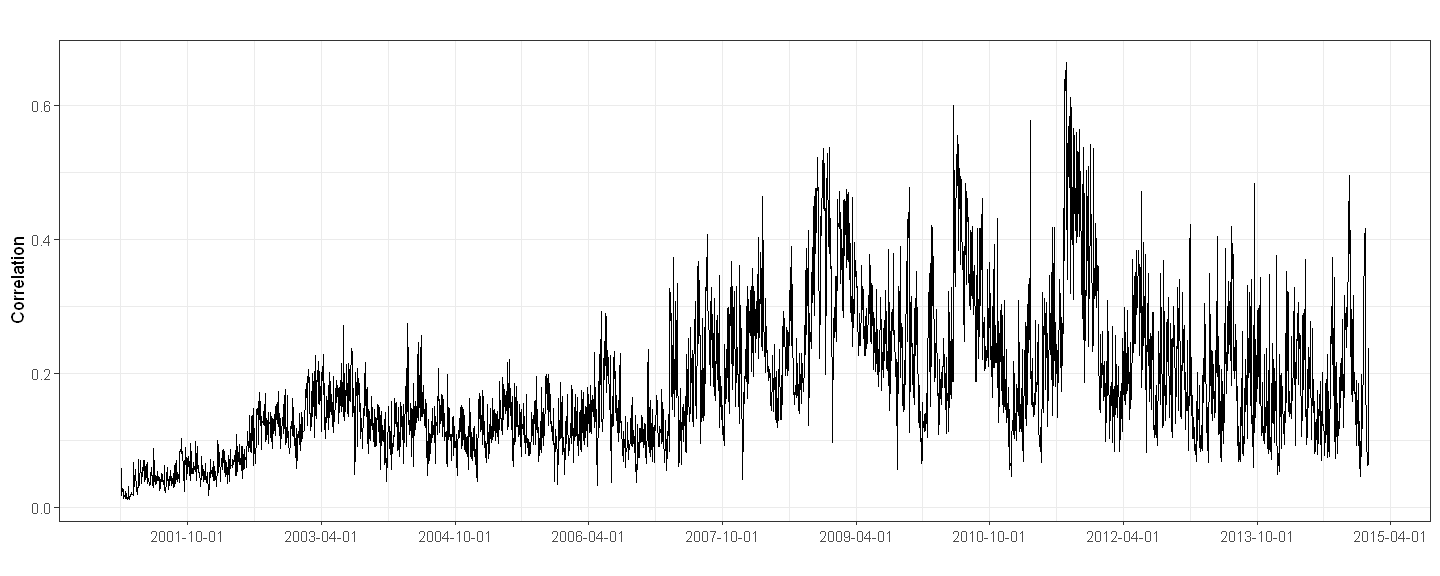

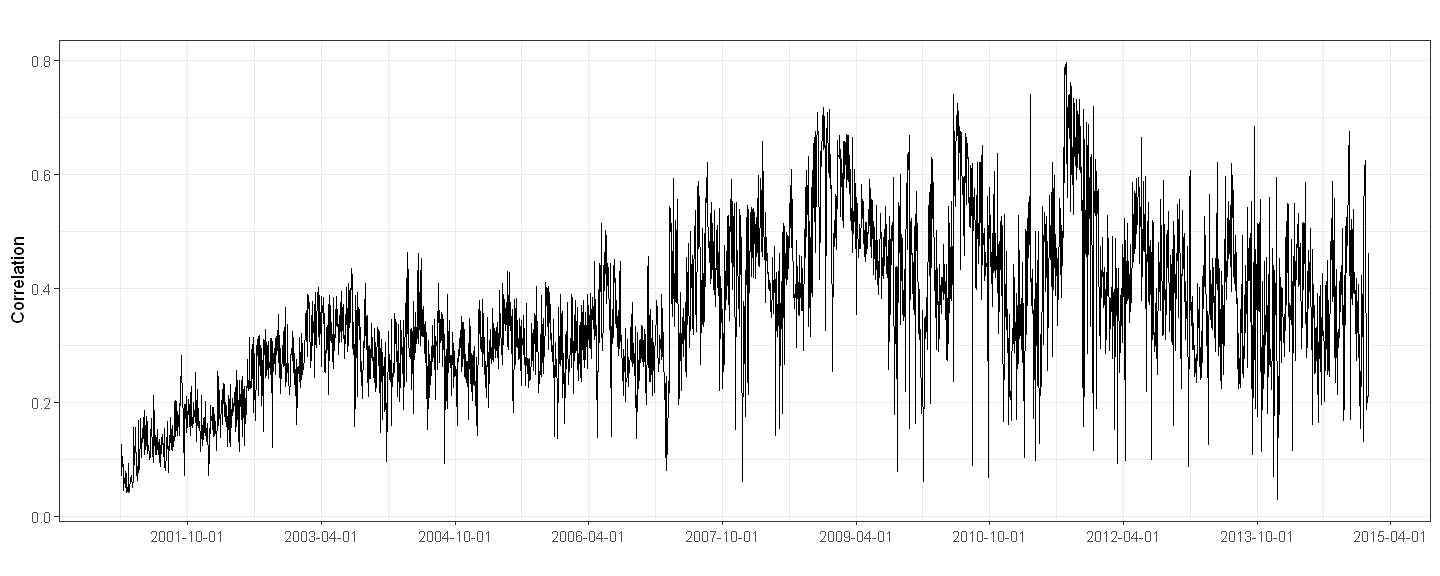

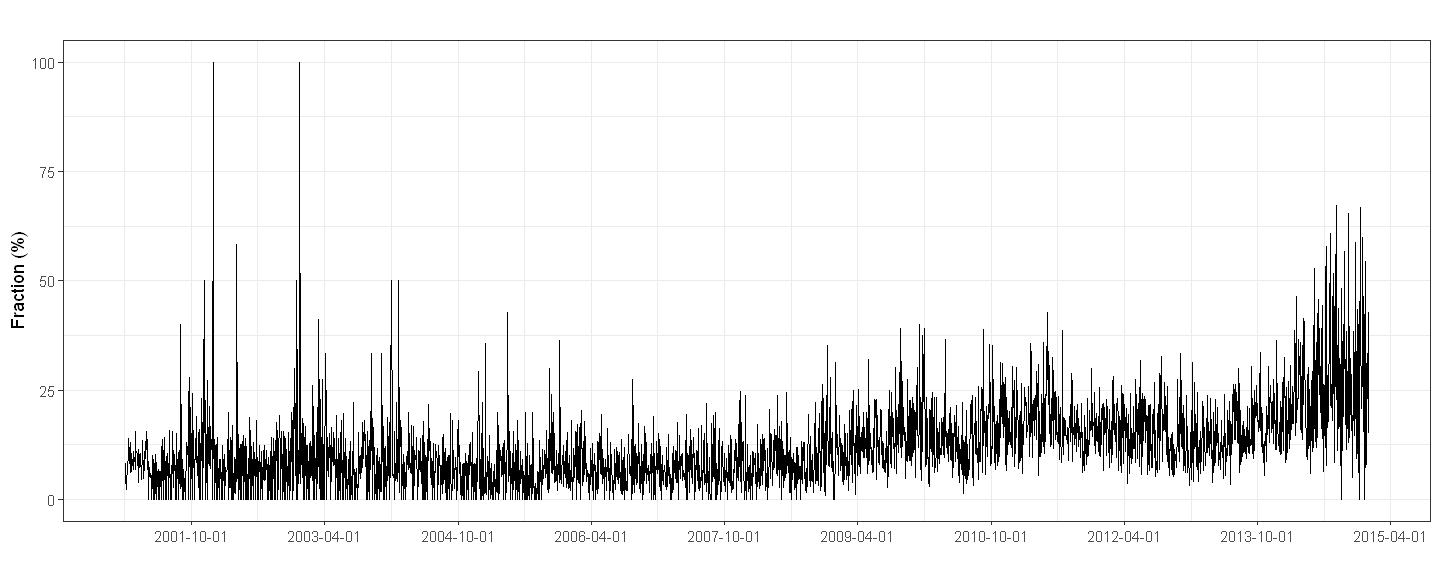

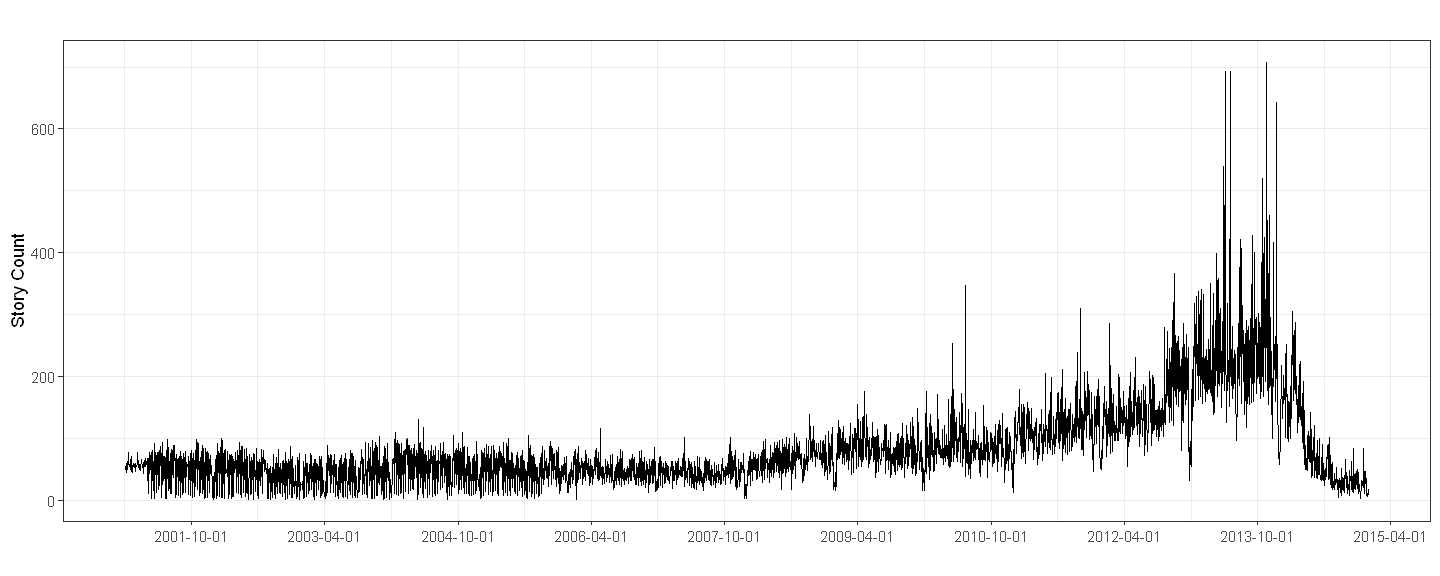

In [6]:
# Time plots

period <- "20010101/20150101"

df <- as.data.frame(dataset)
df$date <- index(dataset)

ggplot(df, aes(x=date, y=pair_1m)) + geom_line() + labs(title="", y="Correlation", x="") + theme_bw() + scale_x_date(date_labels="%Y-%m-%d", date_breaks="18 months")
ggplot(df, aes(x=date, y=mkt_1m)) + geom_line() + labs(title="", y="Correlation", x="") + theme_bw() + scale_x_date(date_labels="%Y-%m-%d", date_breaks="18 months")
ggplot(df, aes(x=date, y=frac*100)) + geom_line() + labs(title="", y="Fraction (%)", x="") + theme_bw() + scale_x_date(date_labels="%Y-%m-%d", date_breaks="18 months")
ggplot(df, aes(x=date, y=total)) + geom_line() + labs(title="", y="Story Count", x="") + theme_bw() + scale_x_date(date_labels="%Y-%m-%d", date_breaks="18 months")

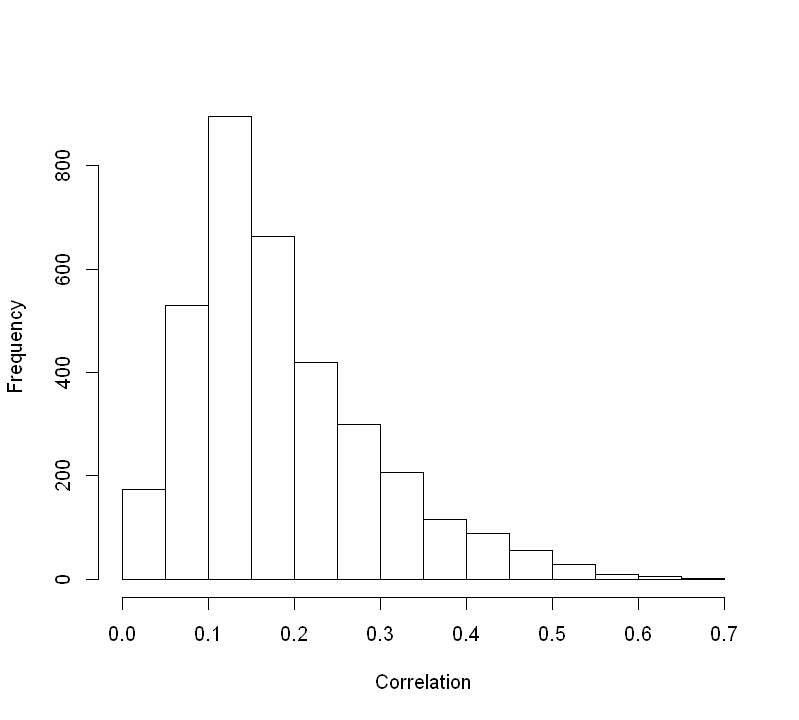

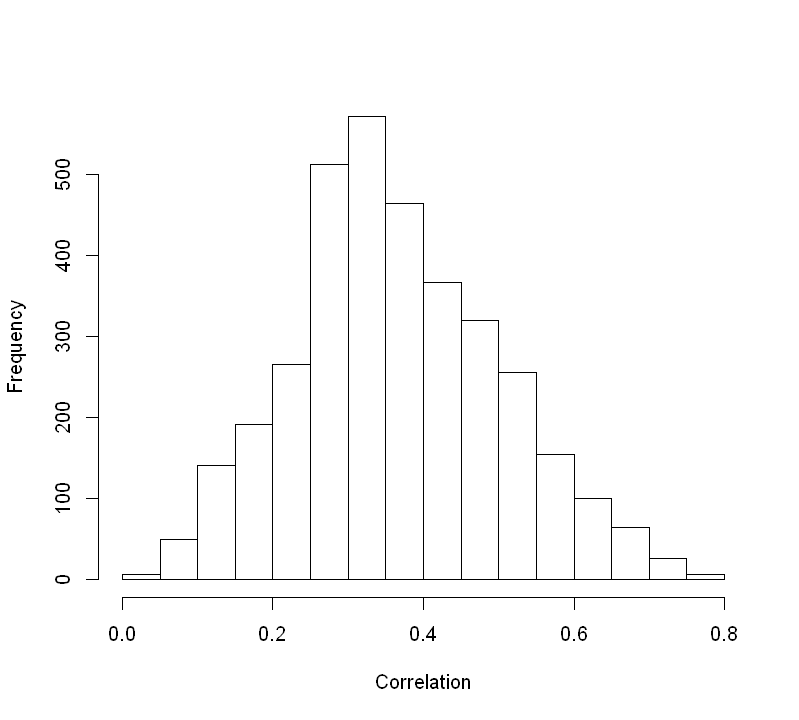

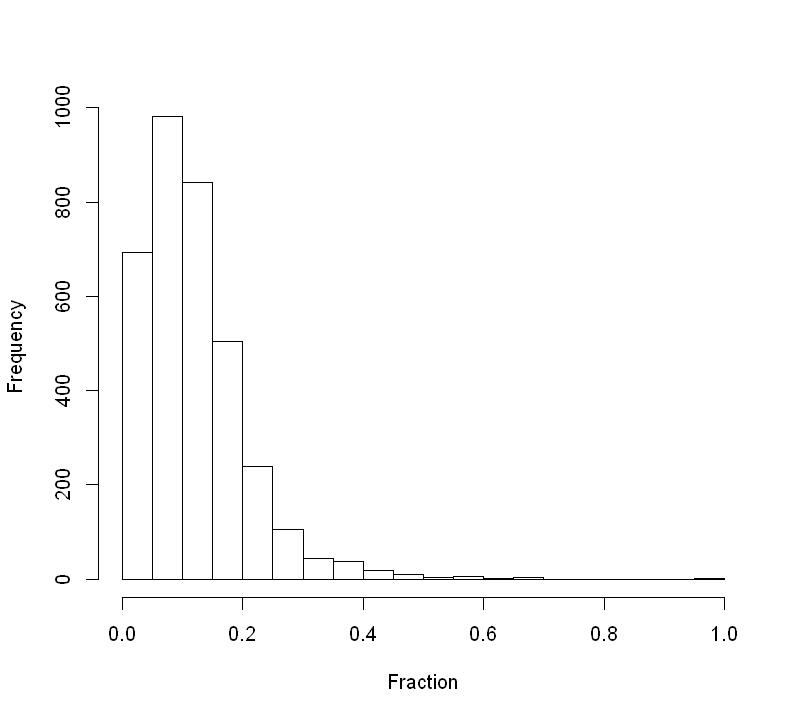

In [7]:
# Histograms
options(repr.plot.width=width/1.8, repr.plot.height=width/2)
    hist(as.xts(dataset$pair_1m)[period], main="", xlab="Correlation")
    hist(as.xts(dataset$mkt_1m)[period], main="", xlab="Correlation")
    hist(as.xts(dataset$frac)[period], main="", breaks=seq(0,1,0.05), xlab="Fraction")
options(repr.plot.width=width, repr.plot.height=width*aspect_ratio)

In [8]:
## Outliers

# Total stories
total_outliers_idx <- sort(as.numeric(dataset$total), decreasing=TRUE, index.return=TRUE)
dataset$total[total_outliers_idx[[2]][1:4]]

# NEWFRC 
frac_outliers_idx <- index(frac)[which(frac==max(frac))]
dataset[frac_outliers_idx, c("frac","pair_1m", "mkt_1m")]

rm(total_outliers_idx, frac_outliers_idx)

2013-05-21 2013-06-10 2013-11-07 2013-12-18 
       693        693        708        642 

           frac  pair_1m   mkt_1m
2001-12-31    1 0.034545 0.116040
2002-12-20    1 0.059213 0.161035

# Relationship (Levels)

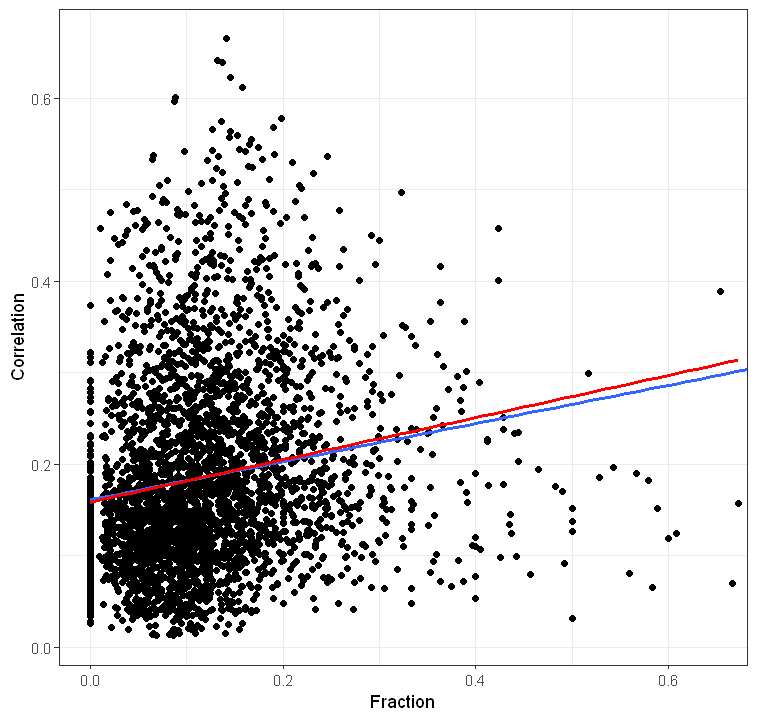

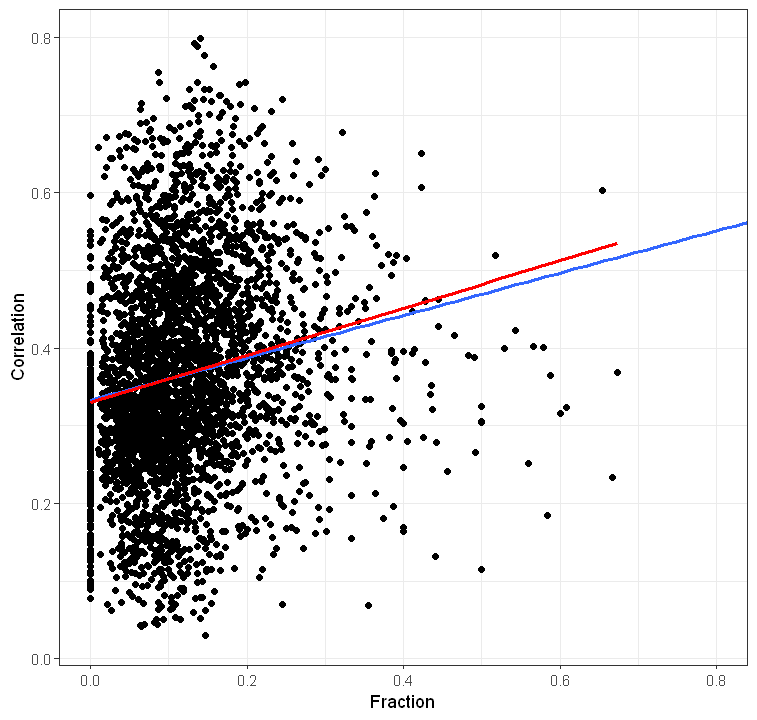

In [9]:
options(repr.plot.width=width/1.9, repr.plot.height=width/2)

# Pairwise
ggplot(data=dataset, aes(x=frac, y=pair_1m)) +
    geom_point() +
    geom_smooth(method="lm", formula=y~x, se=FALSE) +
    geom_smooth(data=subset(dataset, frac < 1), method="lm", formula=y~x, se=FALSE, col="red") +
    coord_cartesian(xlim=c(0, 0.65)) +
    labs(x="Fraction", y="Correlation") + theme_bw()

# Market
ggplot(data=dataset, aes(x=frac, y=mkt_1m)) +
    geom_point() +
    geom_smooth(method="lm", formula=y~x, se=FALSE) +
    geom_smooth(data=subset(dataset, frac < 1), method="lm", formula=y~x, se=FALSE, col="red") +
    coord_cartesian(xlim=c(0, 0.8)) +
    labs(x="Fraction", y="Correlation") + theme_bw()

options(repr.plot.width=width, repr.plot.height=width*aspect_ratio)

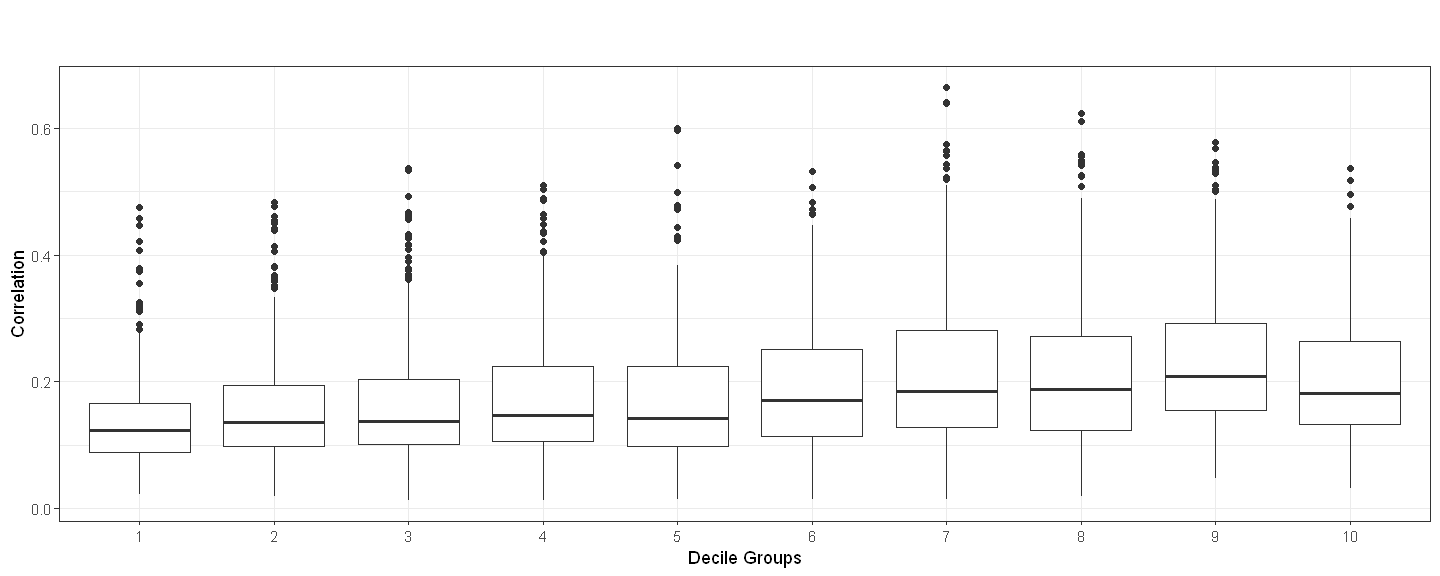

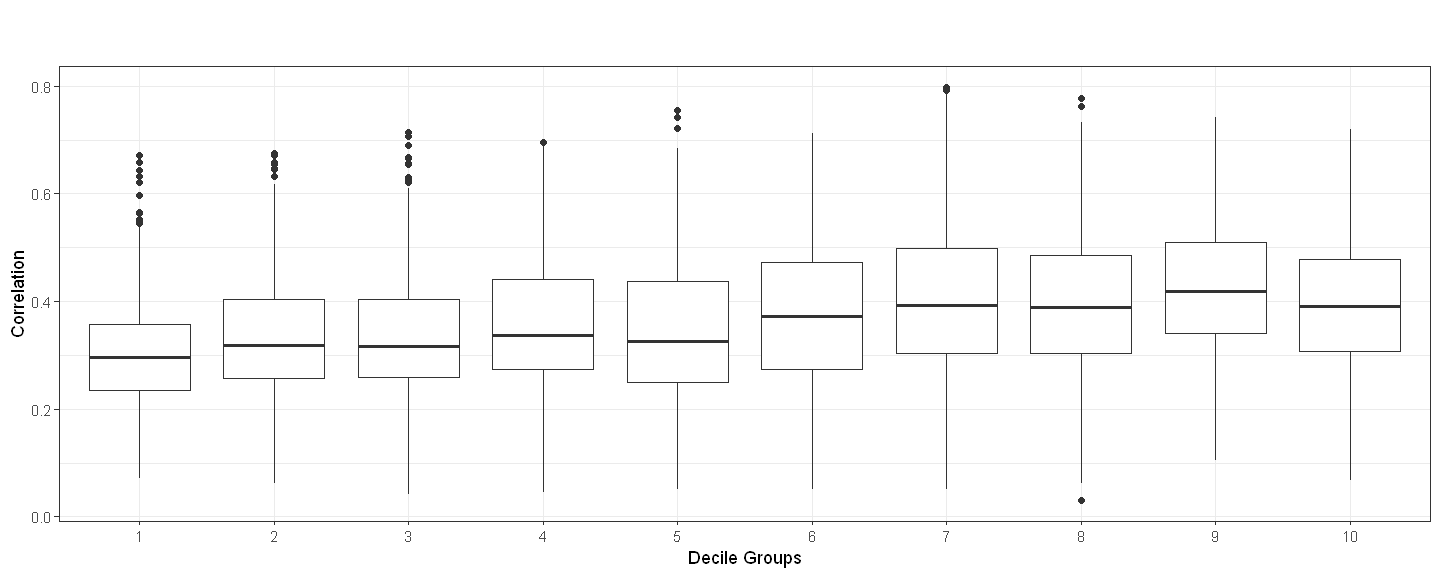

In [10]:
# Stock-correlation per quantile groups of macroeconomic news as a fraction of total news
n_group <- 10

d <- dataset
d$qle <- as.numeric(NA)
qle <- quantile(d$frac,seq(0, 1, 1/n_group))

for (i in length(qle):2) {
    d$qle[d$frac <= qle[i]] <- i-1
}

ggplot(d, aes(x=factor(qle), y=pair_1m)) +
    geom_boxplot() +
    #coord_cartesian(ylim=c(0, 0.85)) +
    labs(x="Decile Groups", y="Correlation", title="", subtitle="") +
    #labs(x="Decile Groups", y="Correlation", title="Stock-correlation per quantile groups of macroeconomic news as a fraction of total news", subtitle="Correlation: Pairwise \n Frequency: 1 minute")
    theme_bw()

ggplot(d, aes(x=factor(qle), y=mkt_1m)) +
    geom_boxplot() +
    #coord_cartesian(ylim=c(0, 0.85)) +
    labs(x="Decile Groups", y="Correlation", title="", subtitle="") +
    #labs(x="Decile Groups", y="Correlation", title="Stock-correlation per quantile groups of macroeconomic news as a fraction of total news", subtitle="Correlation: Pairwise \n Frequency: 1 minute")
    theme_bw()

rm(d, n_group)

# Stationarity test of levels

In [11]:
# Rule of thumb for number of lags (Schwert, 1989)
T <- dim(dataset)[1]
k <- trunc(12 * (T/100)^0.25)
T
k

[1] 3489

[1] 29

## ADF Test

Augmented Dickey-Fuller Test (ADF) - $H_0$ : Non-Stationarity (Unit Root) vs. $H_1$ : Stationarity

Critical value for a significance level of 10%: -1.62

Critical value for a significance level of  5%: -1.95

Critical value for a significance level of  1%: -2.58

In [12]:
ur.df(pair_1m, lags=k, type="none")
ur.df(mkt_1m,  lags=k, type="none")
ur.df(frac,    lags=k, type="none")


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -1.5935 



############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -0.7966 



############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -0.5228 


## KPSS

We test $H_0$: stationarity vs. $H_1$ : non-stationarity

Critical value for a significance level of 10%: 0.347

Critical value for a significance level of  5%: 0.463

Critical value for a significance level of  1%: 0.739

In [13]:
ur.kpss(pair_1m, type="mu", use.lag=k)
ur.kpss(mkt_1m,  type="mu", use.lag=k)
ur.kpss(frac,    type="mu", use.lag=k)


####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 4.6991 



####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 5.7856 



####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 7.2933 


# Stationarity Tests (1st Differences)

In [14]:
# Rule of thumb for number of lags (Schwert, 1989)
T <- dim(dataset)[1] - 1    # Subtract 1 because of the differencing
k <- trunc(12 * (T/100)^0.25)
T
k

[1] 3488

[1] 29

## ADF

In [15]:
ur.df(diff(pair_1m), lags=k, type="none")
ur.df(diff(mkt_1m),  lags=k, type="none")
ur.df(diff(frac),    lags=k, type="none")


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -13.669 



############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -14.6259 



############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -15.5878 


## KPSS

In [16]:
ur.kpss(diff(pair_1m), type="mu", use.lag=k)
ur.kpss(diff(mkt_1m),  type="mu", use.lag=k)
ur.kpss(diff(frac),    type="mu", use.lag=k)


####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 0.009 



####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 0.0105 



####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 0.0239 


In [17]:
d <- dataset
d$diff_pair_1m <- diff(dataset$pair_1m)
d$diff_mkt_1m <- diff(dataset$mkt_1m)
d$diff_frac <- diff(dataset$frac)

summary(d)
sd(d$diff_pair_1m, na.rm=TRUE)
sd(d$diff_mkt_1m, na.rm=TRUE)
sd(d$diff_frac, na.rm=TRUE)

dim(dataset)

rm(d)

     Index                total            macro            frac        
 Min.   :2001-01-03   Min.   :  1.00   Min.   :  0.0   Min.   :0.00000  
 1st Qu.:2004-08-10   1st Qu.: 49.00   1st Qu.:  3.0   1st Qu.:0.06061  
 Median :2008-01-28   Median : 68.00   Median :  7.0   Median :0.10448  
 Mean   :2008-01-21   Mean   : 86.51   Mean   : 11.4   Mean   :0.11867  
 3rd Qu.:2011-07-13   3rd Qu.:101.00   3rd Qu.: 15.0   3rd Qu.:0.15789  
 Max.   :2014-12-31   Max.   :708.00   Max.   :233.0   Max.   :1.00000  
                                                                        
     mkt_1m           pair_1m         diff_pair_1m         diff_mkt_1m        
 Min.   :0.02991   Min.   :0.01255   Min.   :-0.3705810   Min.   :-0.5233390  
 1st Qu.:0.27454   1st Qu.:0.11004   1st Qu.:-0.0305438   1st Qu.:-0.0430220  
 Median :0.35158   Median :0.15901   Median :-0.0002185   Median : 0.0002100  
 Mean   :0.36521   Mean   :0.18566   Mean   : 0.0000514   Mean   : 0.0000959  
 3rd Qu.:0.45845   3r

[1] 0.06146161

[1] 0.08941884

[1] 0.09741625

[1] 3489    5

# Data Exploration (1st Differences)

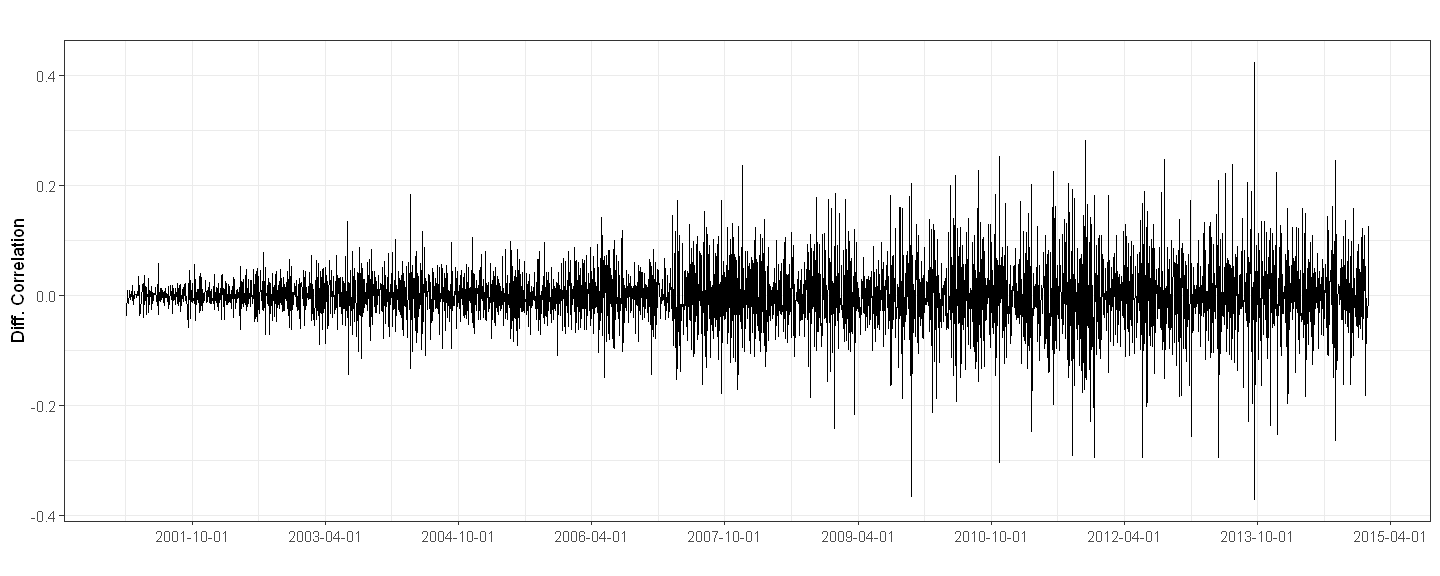

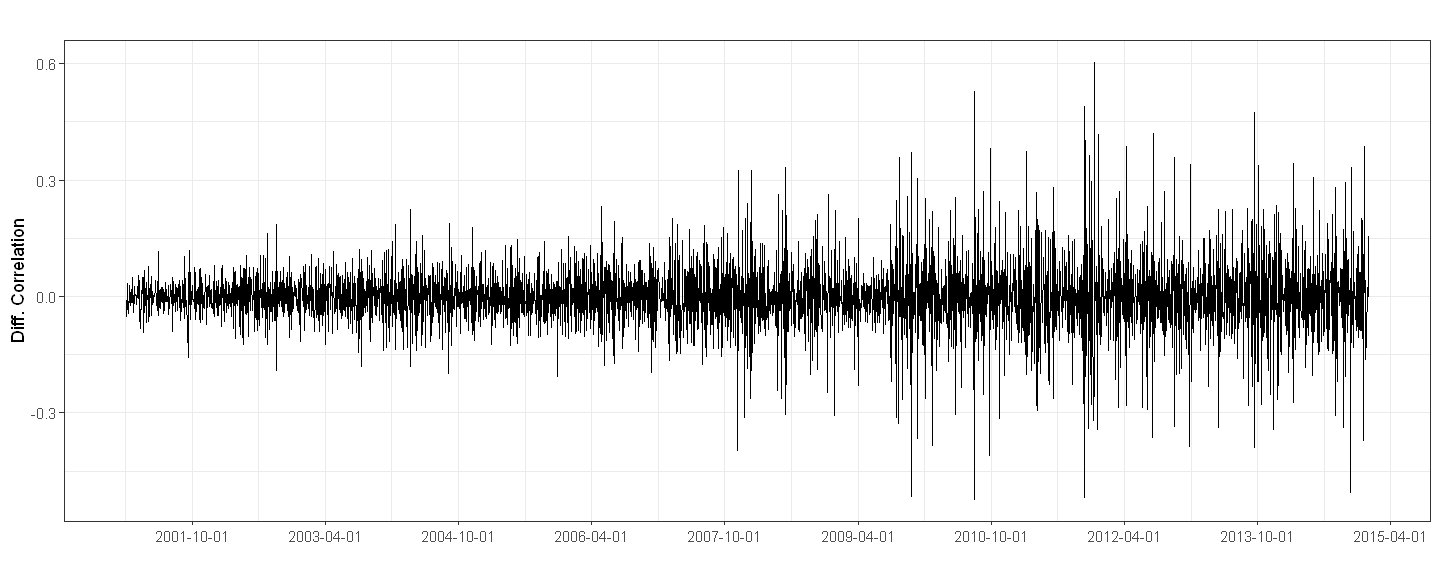

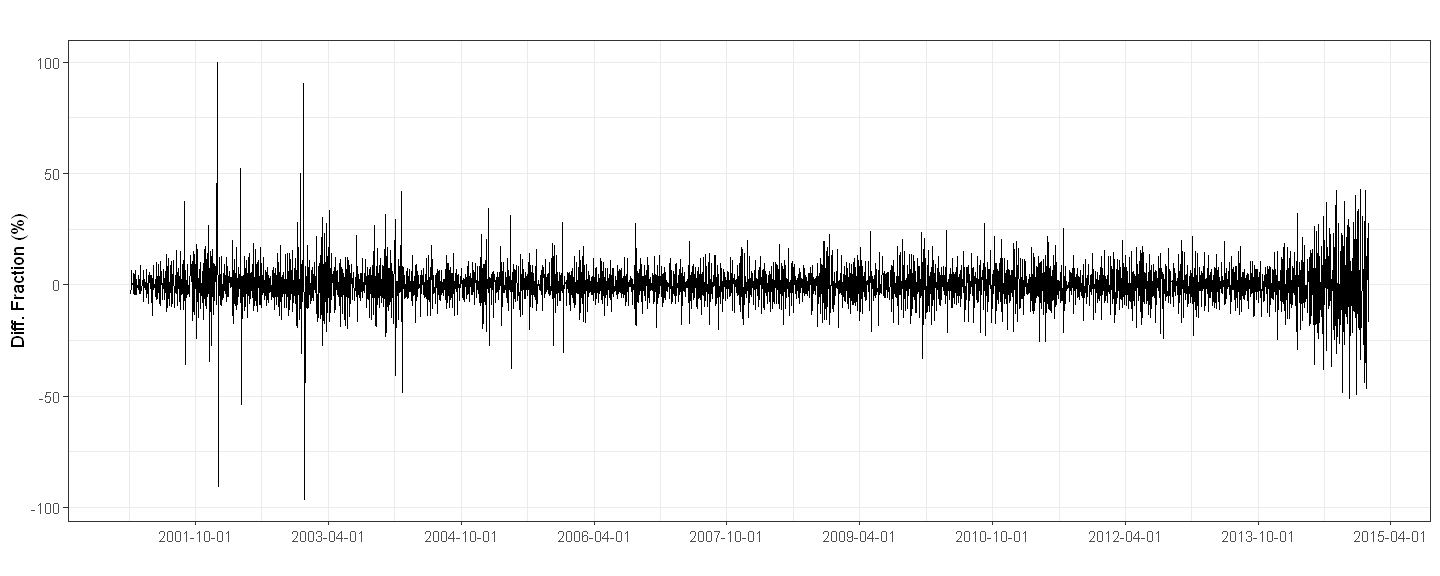

In [18]:
# Time plots of 1st differences

period <- "20010101/20150101"

diff_pair_1m <- diff(dataset$pair_1m)
diff_mkt_1m <- diff(dataset$mkt_1m)
diff_frac <- diff(dataset$frac)

d <- data.frame(diff_pair_1m=diff_pair_1m,
                diff_mkt_1m=diff_mkt_1m,
                diff_frac=diff_frac)
d$date <- index(diff_pair_1m)


ggplot(d, aes(x=date, y=diff_pair_1m)) + geom_line() + labs(title="", y="Diff. Correlation", x="") + theme_bw() + scale_x_date(date_labels="%Y-%m-%d", date_breaks="18 months")
ggplot(d, aes(x=date, y=diff_mkt_1m)) + geom_line() + labs(title="", y="Diff. Correlation", x="") + theme_bw() + scale_x_date(date_labels="%Y-%m-%d", date_breaks="18 months")
ggplot(d, aes(x=date, y=diff_frac*100)) + geom_line() + labs(title="", y="Diff. Fraction (%)", x="") + theme_bw() + scale_x_date(date_labels="%Y-%m-%d", date_breaks="18 months")

rm(d)

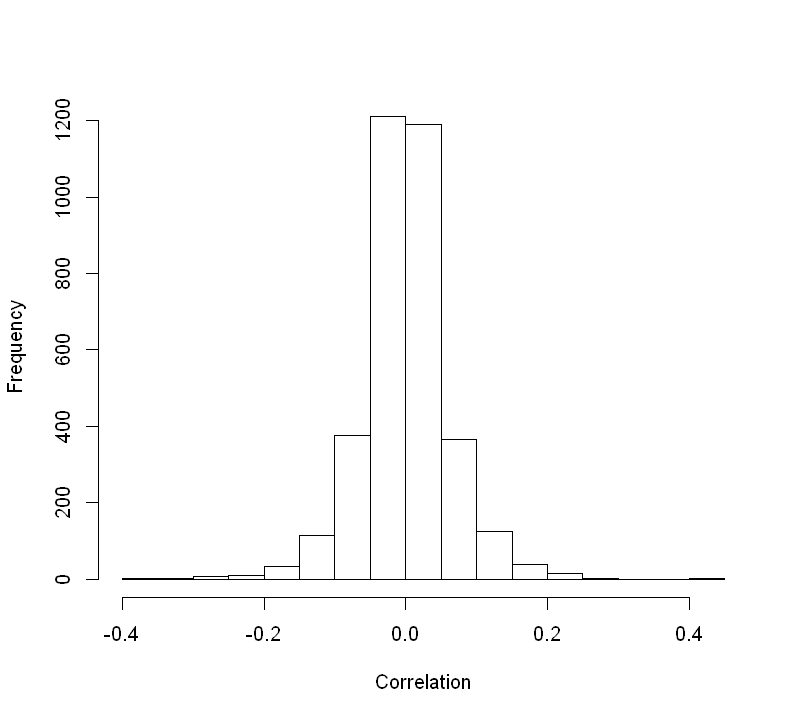

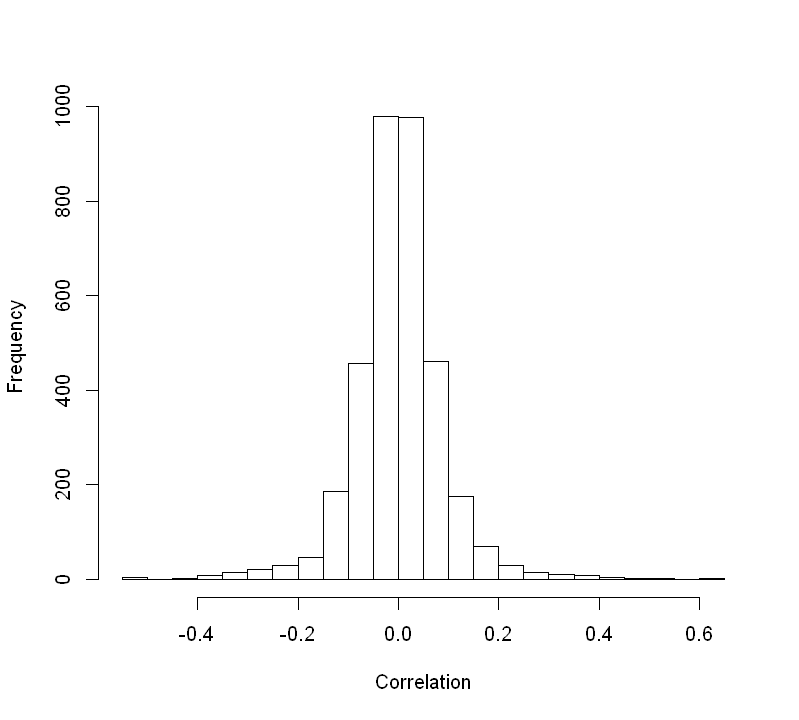

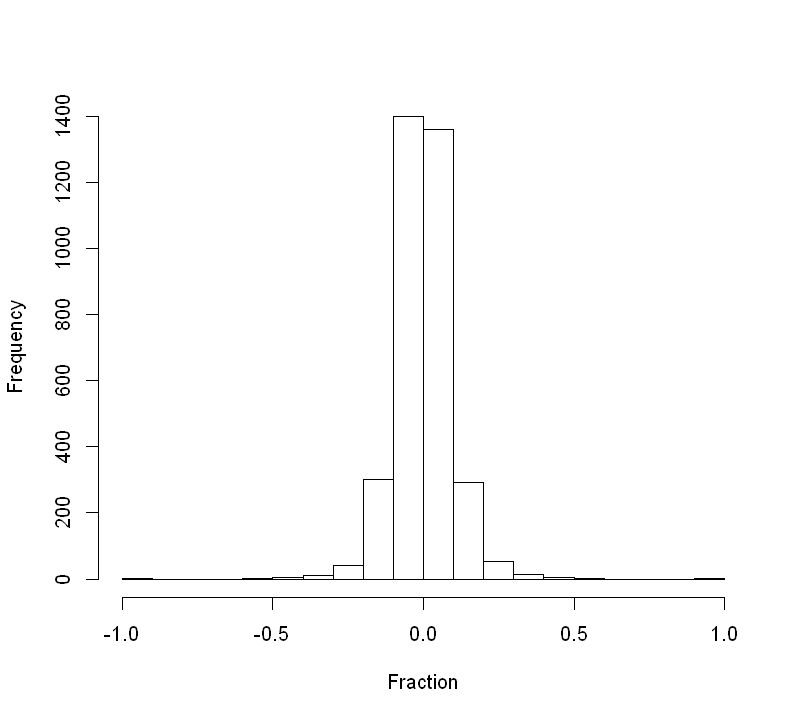

In [19]:
# Histograms
options(repr.plot.width=width/1.8, repr.plot.height=width/2)
    hist(as.xts(diff(dataset$pair_1m))[period], main="", xlab="Correlation", breaks=20)
    hist(as.xts(diff(dataset$mkt_1m))[period], main="", xlab="Correlation", breaks=20)
    hist(as.xts(diff(dataset$frac))[period], main="", xlab="Fraction", breaks=20)
options(repr.plot.width=width, repr.plot.height=width*aspect_ratio)

# Relationship (1st Differences)

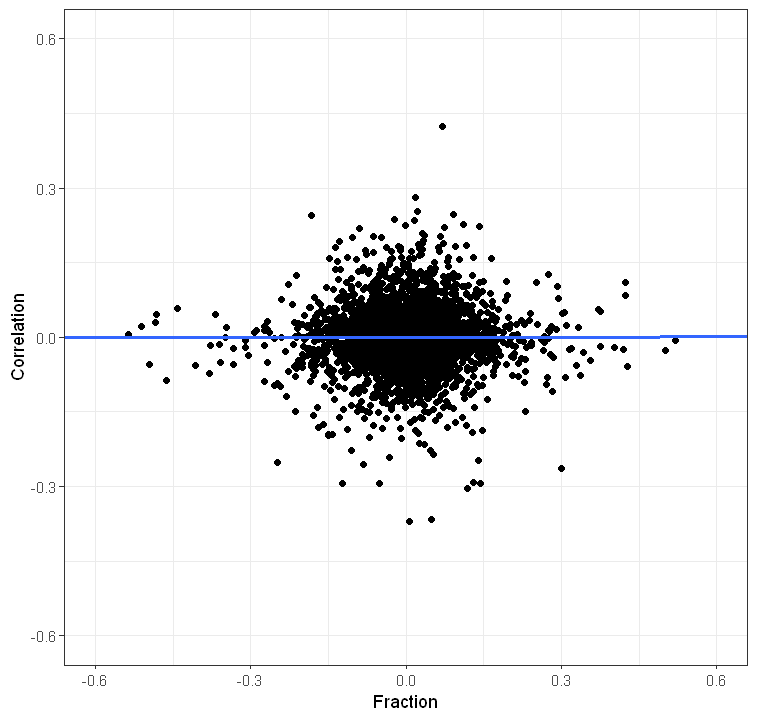

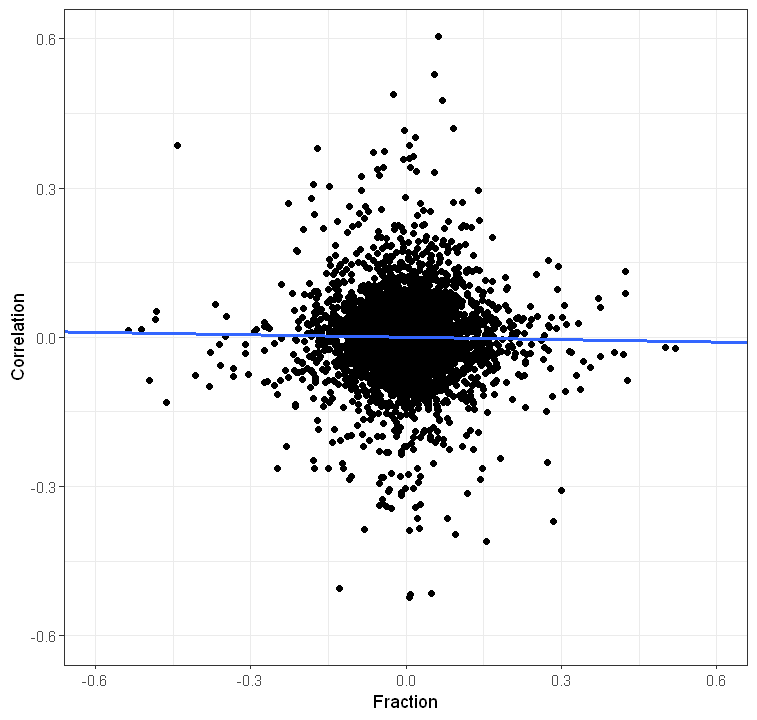

In [20]:
# Scatter plots
options(repr.plot.width=width/1.9, repr.plot.height=width/2)

    ggplot(data=diff(dataset), aes(x=frac, y=pair_1m)) +
        geom_point() +
        geom_smooth(method="lm", formula=y~x, se=FALSE) +
        coord_cartesian(xlim=c(-0.6, 0.6), ylim=c(-0.6, 0.6)) +
        labs(x="Fraction", y="Correlation") + theme_bw()
    
    ggplot(data=diff(dataset), aes(x=frac, y=mkt_1m)) +
        geom_point() +
        geom_smooth(method="lm", formula=y~x, se=FALSE) +
        coord_cartesian(xlim=c(-0.6, 0.6), ylim=c(-0.6, 0.6)) +
        labs(x="Fraction", y="Correlation") + theme_bw()

options(repr.plot.width=width, repr.plot.height=width*aspect_ratio)

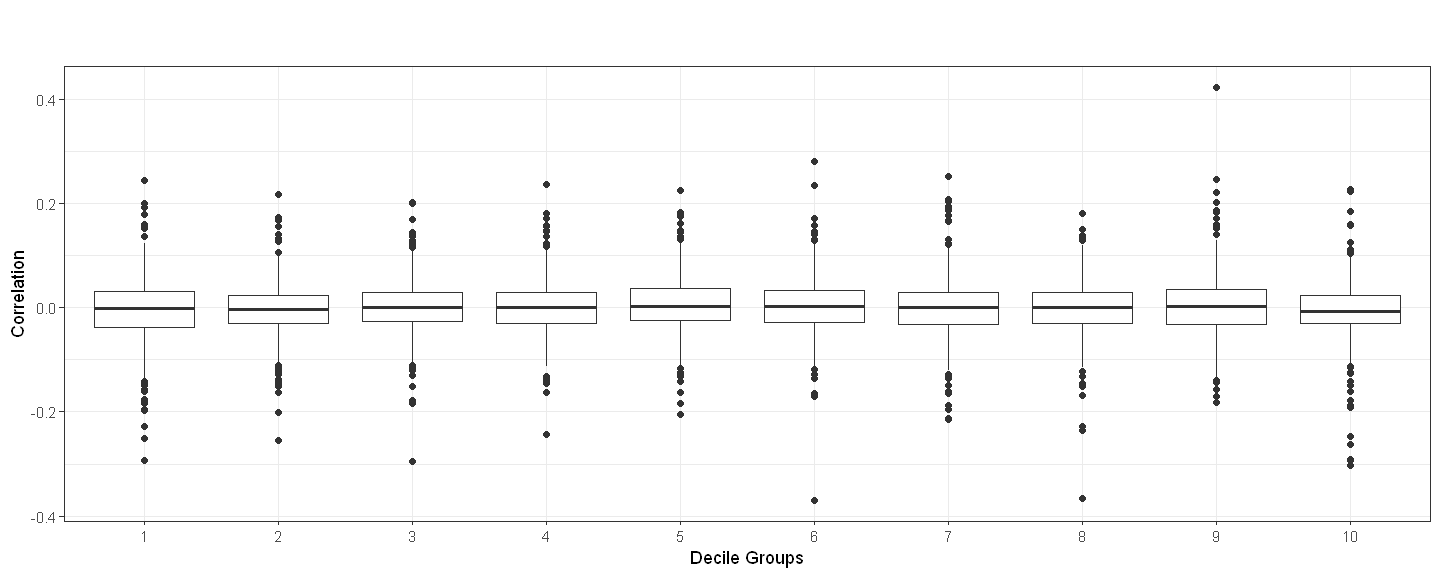

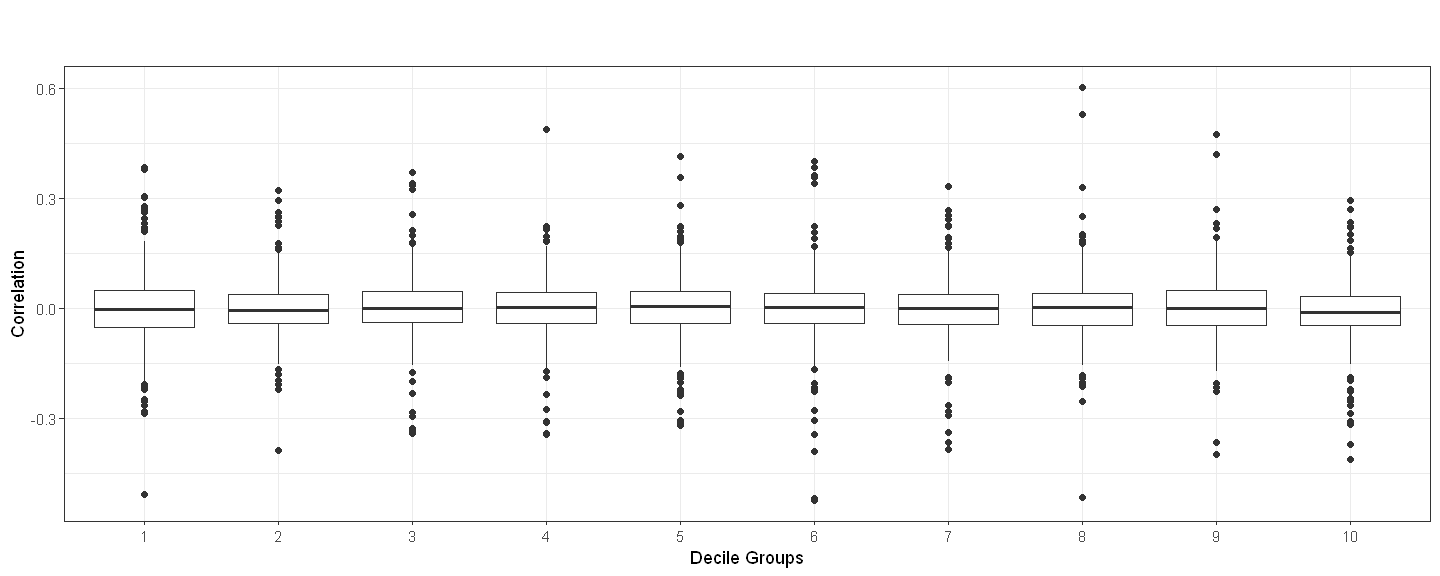

In [21]:
# Stock-correlation per quantile groups of macroeconomic news as a fraction of total news
n_group <- 10

diff_pair_1m <- diff(dataset$pair_1m)
diff_mkt_1m <- diff(dataset$mkt_1m)
diff_frac <- diff(dataset$frac)

d <- data.frame(diff_pair_1m=diff_pair_1m,
                diff_mkt_1m=diff_mkt_1m,
                diff_frac=diff_frac)

d$qle <- as.numeric(NA)
qle <- quantile(diff_frac, seq(0, 1, 1/n_group))

for (i in length(qle):2) {
    d$qle[d$diff_frac <= qle[i]] <- i-1
}


ggplot(d, aes(x=factor(qle), y=diff_pair_1m)) +
    geom_boxplot() +
    #coord_cartesian(ylim=c(0, 0.85)) +
    labs(x="Decile Groups", y="Correlation", title="", subtitle="") +
    #labs(x="Decile Groups", y="Correlation", title="Stock-correlation per quantile groups of macroeconomic news as a fraction of total news", subtitle="Correlation: Pairwise \n Frequency: 1 minute")
    theme_bw()

ggplot(d, aes(x=factor(qle), y=diff_mkt_1m)) +
    geom_boxplot() +
    #coord_cartesian(ylim=c(0, 0.85)) +
    labs(x="Decile Groups", y="Correlation", title="", subtitle="") +
    #labs(x="Decile Groups", y="Correlation", title="Stock-correlation per quantile groups of macroeconomic news as a fraction of total news", subtitle="Correlation: Pairwise \n Frequency: 1 minute")
    theme_bw()

rm(d, n_group)

# Engle-Granger Test for Cointegration

In [22]:
# Estimate model
fit_pair_1m <- dynlm(pair_1m ~ frac)
fit_mkt_1m  <- dynlm(mkt_1m  ~ frac)

# Test whether residuals for stationarity, i.e. I(0)
ur.df(fit_pair_1m$residuals, lags=k, type="none")
ur.df(fit_mkt_1m$residuals,  lags=k, type="none")


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -4.314 



############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -4.0514 


In [23]:
fit_pair_1m
fit_mkt_1m


Time series regression with "zoo" data:
Start = 2001-01-03, End = 2014-12-31

Call:
dynlm(formula = pair_1m ~ frac)

Coefficients:
(Intercept)         frac  
     0.1609       0.2085  



Time series regression with "zoo" data:
Start = 2001-01-03, End = 2014-12-31

Call:
dynlm(formula = mkt_1m ~ frac)

Coefficients:
(Intercept)         frac  
     0.3329       0.2726  


# Equilibrium Correction Model

In [24]:
# Get error correction terms
ect_pair_1m <- fit_pair_1m$residuals
ect_mkt_1m  <- fit_mkt_1m$residuals


# Estimate equilibrium correction model (ECM)
ecm_pair_1m <- dynlm(d(pair_1m) ~ d(frac) + L(ect_pair_1m) - 1)
ecm_mkt_1m  <- dynlm(d(mkt_1m) ~ d(frac) + L(ect_mkt_1m) - 1)

summary(ecm_pair_1m)
summary(ecm_mkt_1m )


Time series regression with "zoo" data:
Start = 2001-01-04, End = 2014-12-31

Call:
dynlm(formula = d(pair_1m) ~ d(frac) + L(ect_pair_1m) - 1)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.32225 -0.03237 -0.00684  0.02758  0.40081 

Coefficients:
                Estimate Std. Error t value            Pr(>|t|)    
d(frac)         0.019518   0.010273    1.90              0.0575 .  
L(ect_pair_1m) -0.170603   0.009482  -17.99 <0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0588 on 3486 degrees of freedom
Multiple R-squared:  0.08497,	Adjusted R-squared:  0.08444 
F-statistic: 161.9 on 2 and 3486 DF,  p-value: < 0.00000000000000022



Time series regression with "zoo" data:
Start = 2001-01-04, End = 2014-12-31

Call:
dynlm(formula = d(mkt_1m) ~ d(frac) + L(ect_mkt_1m) - 1)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.46781 -0.04543 -0.00318  0.04471  0.54350 

Coefficients:
              Estimate Std. Error t value            Pr(>|t|)    
d(frac)        0.01794    0.01475   1.216               0.224    
L(ect_mkt_1m) -0.22217    0.01067 -20.818 <0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.08433 on 3486 degrees of freedom
Multiple R-squared:  0.1109,	Adjusted R-squared:  0.1103 
F-statistic: 217.3 on 2 and 3486 DF,  p-value: < 0.00000000000000022


In [25]:
# HAC Standard Errors (Newey West)
coeftest(ecm_pair_1m, vcov. = NeweyWest(ecm_pair_1m, prewhite = F, adjust = T))
coeftest(ecm_mkt_1m, vcov.  = NeweyWest(ecm_mkt_1m, prewhite = F, adjust = T))


t test of coefficients:

                Estimate Std. Error t value             Pr(>|t|)    
d(frac)         0.019518   0.010871  1.7955              0.07267 .  
L(ect_pair_1m) -0.170603   0.019249 -8.8632 < 0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



t test of coefficients:

               Estimate Std. Error t value            Pr(>|t|)    
d(frac)        0.017938   0.016945  1.0586              0.2898    
L(ect_mkt_1m) -0.222173   0.025998 -8.5458 <0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [26]:
# Stationarity of residuals
ur.df(ecm_pair_1m$residuals, lags=k, type="none")
ur.df(ecm_mkt_1m$residuals,  lags=k, type="none")


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -4.6951 



############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -4.3943 


In [27]:
# E(z_t) = 0
mean(ecm_pair_1m$residuals)
mean(ecm_mkt_1m$residuals)

[1] 0.00005010864

[1] 0.00009336184

In [28]:
# Corr(z_t, x_t) = 0
cor(ecm_pair_1m$residuals, diff(frac), use="na.or.complete")
cor(ecm_pair_1m$residuals, lag(ect_pair_1m, k=-1))
cor(ecm_mkt_1m$residuals, diff(frac), use="na.or.complete")
cor(ecm_mkt_1m$residuals, lag(ect_mkt_1m, k=-1))

[1] -0.0000008662154

[1] -0.0000000294326

[1] -0.000001125355

[1] 0.00000002827624

In [29]:
# Heteroscedasticity - White's test (1980)
d <- data.frame(d_frac = diff(frac),
                L_ect_pair_1m = lag(ect_pair_1m, k=-1),
                L_ect_mkt_1m = lag(ect_mkt_1m, k=-1))

bptest(ecm_pair_1m, ~ d_frac + L_ect_pair_1m + I(d_frac^2) + I(L_ect_pair_1m^2) + I(d_frac*L_ect_pair_1m), data=d)
bptest(ecm_mkt_1m, ~ d_frac + L_ect_mkt_1m + I(d_frac^2) + I(L_ect_mkt_1m^2) + I(d_frac*L_ect_mkt_1m), data=d)

rm(d)


	studentized Breusch-Pagan test

data:  ecm_pair_1m
BP = 224.46, df = 5, p-value < 0.00000000000000022



	studentized Breusch-Pagan test

data:  ecm_mkt_1m
BP = 44.497, df = 5, p-value = 0.00000001836


In [30]:
# Autocorrelation - Breusch-Godfrey
bgtest(ecm_pair_1m, order=k)
bgtest(ecm_mkt_1m, order=k)


	Breusch-Godfrey test for serial correlation of order up to 29

data:  ecm_pair_1m
LM test = 668.77, df = 29, p-value < 0.00000000000000022



	Breusch-Godfrey test for serial correlation of order up to 29

data:  ecm_mkt_1m
LM test = 793.61, df = 29, p-value < 0.00000000000000022


In [31]:
# Normality - Jarque-Bera
jarque.bera.test(ecm_pair_1m$residuals)
jarque.bera.test(ecm_mkt_1m$residuals)


	Jarque Bera Test

data:  ecm_pair_1m$residuals
X-squared = 1469.4, df = 2, p-value < 0.00000000000000022



	Jarque Bera Test

data:  ecm_mkt_1m$residuals
X-squared = 2323, df = 2, p-value < 0.00000000000000022



	Breusch-Godfrey test for serial correlation of order up to 10

data:  Residuals
LM test = 611.63, df = 10, p-value < 0.00000000000000022


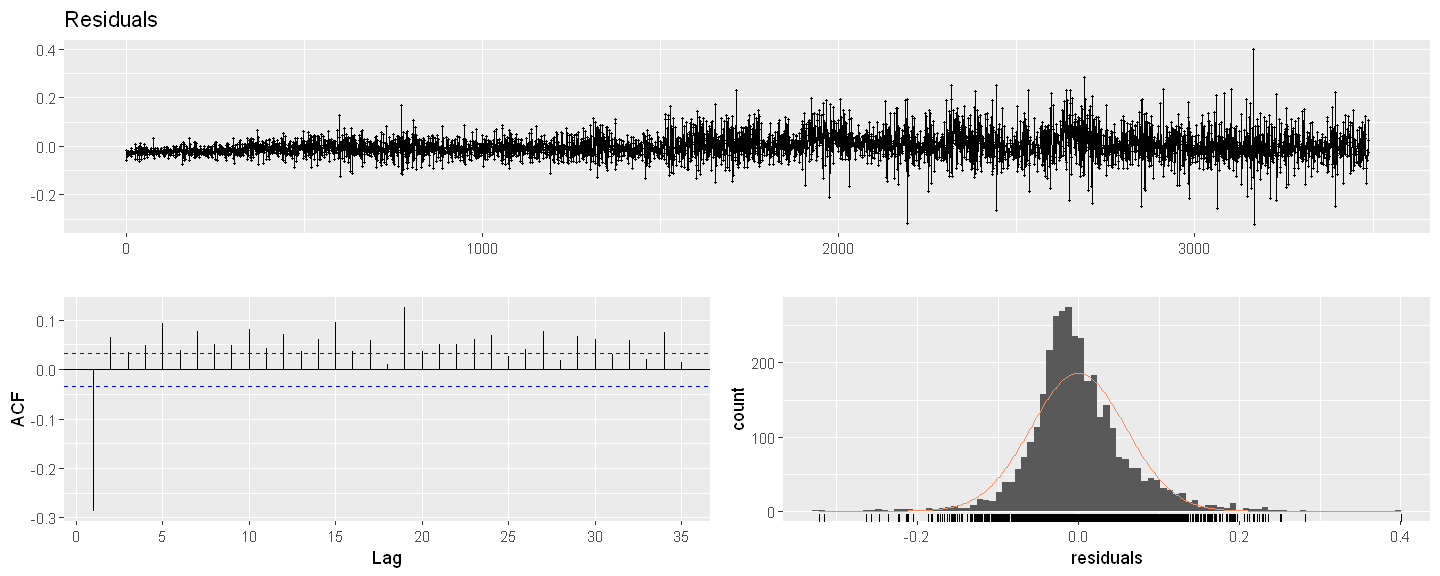


	Breusch-Godfrey test for serial correlation of order up to 10

data:  Residuals
LM test = 714.52, df = 10, p-value < 0.00000000000000022


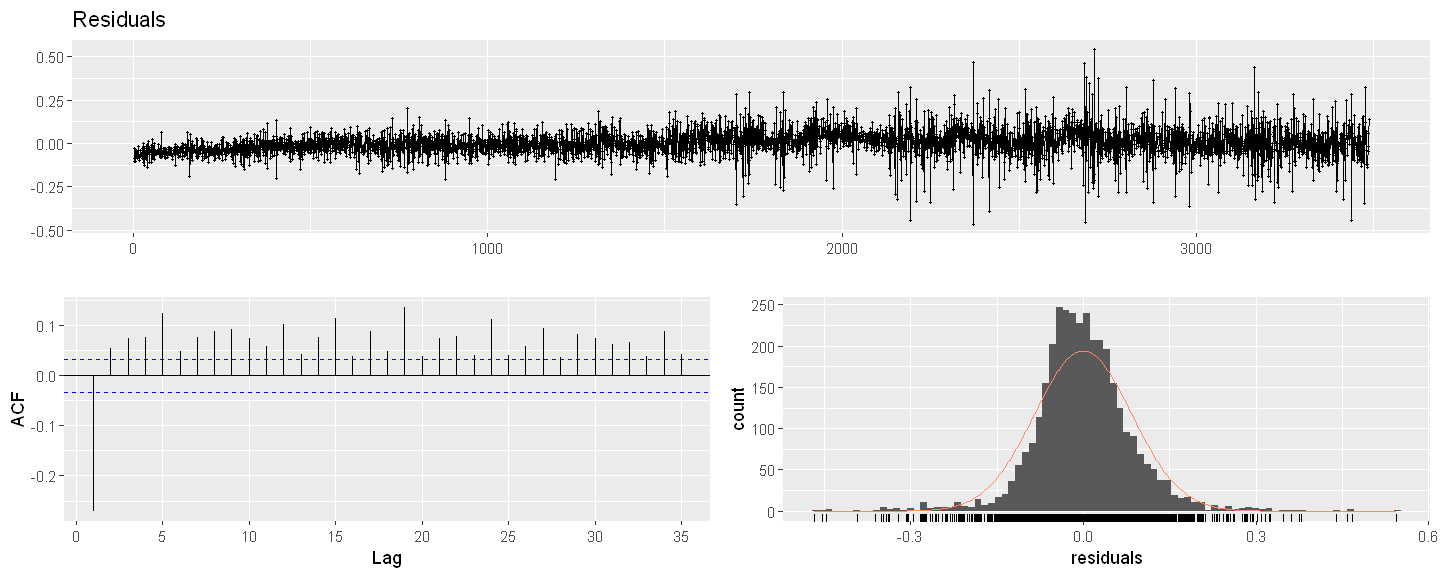

In [32]:
# Visual diagnostic
checkresiduals(ecm_pair_1m)
checkresiduals(ecm_mkt_1m)